# 🌊 Dynamic Mode Decomposition (DMD) Analysis for Sleep EEG

## 📋 Project Overview

This notebook implements **Dynamic Mode Decomposition (DMD)** analysis for EEG sleep signal characterization. DMD is a powerful technique that extracts spatiotemporal modes from complex dynamical systems, making it ideal for analyzing the temporal evolution of brain states during sleep.

## 🎯 Research Objectives

1. **Time-Window Analysis**: Apply DMD to 3-second EEG windows (1536 samples at 512 Hz)
2. **Mode Extraction**: Extract up to 5 dominant DMD modes representing sleep dynamics
3. **Feature Engineering**: Compute phase and amplitude features from eigenvalues and eigenvectors
4. **Temporal Visualization**: Analyze how DMD features evolve over time during sleep
5. **Sleep State Characterization**: Use DMD features for sleep stage discrimination

---

### 🧠 DMD in Sleep Research

Dynamic Mode Decomposition is particularly valuable for sleep EEG analysis because:
- **Captures oscillatory patterns** characteristic of different sleep stages
- **Identifies dominant frequencies** (delta, theta, alpha, beta, gamma bands)
- **Models temporal evolution** of brain state transitions
- **Provides interpretable features** for machine learning classification
- **Handles non-stationary signals** common in sleep recordings

---

### 📊 Expected Features

- **Eigenvalue magnitude & phase**: Stability and oscillatory characteristics
- **Mode amplitudes**: Contribution of each dynamic mode
- **Growth rates**: Temporal evolution patterns
- **Frequencies**: Dominant oscillatory components
- **Complex dynamics**: Phase relationships between modes

---

### 🏥 Clinical Applications

- Sleep stage classification and detection
- Sleep disorder identification (apnea, insomnia)
- Circadian rhythm analysis
- Personalized sleep medicine

In [ ]:
# ==============================================================================
# LIBRARY IMPORTS AND CONFIGURATION
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.linalg import svd
import mne
import warnings
from datetime import datetime
import os

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure plotting environment
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True

def display_environment_info():
    """Display information about the computing environment."""
    print("🔧 COMPUTING ENVIRONMENT")
    print("=" * 30)
    print(f"NumPy version: {np.__version__}")
    print(f"Pandas version: {pd.__version__}")
    print(f"Matplotlib version: {plt.matplotlib.__version__}")
    print(f"Seaborn version: {sns.__version__}")
    print(f"MNE version: {mne.__version__}")
    print(f"SciPy available: ✅")
    print("✅ All libraries imported successfully!")

display_environment_info()

Libraries imported successfully!
NumPy version: 2.3.0
MNE version: 1.9.0
Matplotlib version: 3.10.3


In [ ]:
# ==============================================================================
# DYNAMIC MODE DECOMPOSITION (DMD) IMPLEMENTATION
# ==============================================================================

class EEG_DMD:
    """
    Enhanced Dynamic Mode Decomposition implementation for EEG sleep analysis.
    
    This implementation provides:
    - Standard DMD algorithm with SVD decomposition
    - Feature extraction for machine learning
    - Visualization capabilities
    - Sleep-specific analysis methods
    """
    
    def __init__(self, n_modes=5, truncation_threshold=1e-10):
        """
        Initialize DMD analyzer.
        
        Args:
            n_modes (int): Number of DMD modes to extract
            truncation_threshold (float): SVD truncation threshold
        """
        self.n_modes = n_modes
        self.truncation_threshold = truncation_threshold
        
        # DMD components (computed during fit)
        self.eigenvalues = None
        self.eigenvectors = None
        self.modes = None
        self.amplitudes = None
        self.growth_rates = None
        self.frequencies = None
        
        # Data properties
        self.fitted = False
        self.data_shape = None
        
    def fit(self, X, verbose=True):
        """
        Fit DMD to data matrix X using the standard algorithm.
        
        Args:
            X (np.array): Data matrix where columns are time snapshots
            verbose (bool): Print fitting progress
            
        Returns:
            self: Fitted DMD object
        """
        
        if verbose:
            print(f"🌊 Fitting DMD with {self.n_modes} modes...")
            print(f"  • Data shape: {X.shape}")
        
        self.data_shape = X.shape
        
        # Create time-shifted data matrices
        X1 = X[:, :-1]  # X(0) to X(T-1)
        X2 = X[:, 1:]   # X(1) to X(T)
        
        if verbose:
            print(f"  • X1 shape: {X1.shape}, X2 shape: {X2.shape}")
        
        # Step 1: SVD of X1
        U, S, Vh = svd(X1, full_matrices=False)
        
        # Determine rank for truncation
        rank = min(self.n_modes, len(S), np.sum(S > self.truncation_threshold))
        
        if verbose:
            print(f"  • SVD rank: {rank}")
            print(f"  • Singular values range: [{S[0]:.2e}, {S[-1]:.2e}]")
        
        # Truncate SVD components
        U_r = U[:, :rank]
        S_r = S[:rank]
        V_r = Vh[:rank, :].T
        
        # Step 2: Compute reduced-order operator
        Atilde = U_r.T @ X2 @ V_r @ np.diag(1/S_r)
        
        # Step 3: Eigendecomposition of Atilde
        eigenvals, eigenvecs = np.linalg.eig(Atilde)
        
        # Sort eigenvalues by magnitude (most dominant first)
        idx = np.argsort(np.abs(eigenvals))[::-1]
        eigenvals = eigenvals[idx]
        eigenvecs = eigenvecs[:, idx]
        
        # Step 4: Compute DMD modes
        modes = U_r @ eigenvecs
        
        # Step 5: Compute mode amplitudes
        try:
            amplitudes = np.linalg.pinv(modes) @ X1[:, 0]
        except np.linalg.LinAlgError:
            # Fallback for singular matrices
            amplitudes = np.linalg.lstsq(modes, X1[:, 0], rcond=None)[0]
        
        # Store results
        self.eigenvalues = eigenvals
        self.eigenvectors = eigenvecs
        self.modes = modes
        self.amplitudes = amplitudes
        
        # Compute derived quantities
        self.growth_rates = np.real(np.log(eigenvals))
        self.frequencies = np.imag(np.log(eigenvals))
        
        self.fitted = True
        
        if verbose:
            print(f"  • Eigenvalue magnitudes: {np.abs(eigenvals)}")
            print(f"  • Growth rates: {self.growth_rates}")
            print(f"✅ DMD fitting completed")
        
        return self
    
    def extract_features(self):
        """
        Extract comprehensive features from DMD analysis for ML applications.
        
        Returns:
            dict: Dictionary of DMD features
        """
        
        if not self.fitted:
            raise ValueError("DMD must be fitted before extracting features")
        
        features = {}
        
        # Eigenvalue-based features
        features['eigenval_magnitudes'] = np.abs(self.eigenvalues)
        features['eigenval_phases'] = np.angle(self.eigenvalues)
        features['eigenval_real'] = np.real(self.eigenvalues)
        features['eigenval_imag'] = np.imag(self.eigenvalues)
        
        # Mode amplitude features
        features['mode_amplitudes'] = np.abs(self.amplitudes)
        features['mode_phases'] = np.angle(self.amplitudes)
        
        # Temporal evolution features
        features['growth_rates'] = self.growth_rates
        features['frequencies'] = self.frequencies
        
        # Stability features
        features['stable_modes'] = np.sum(self.growth_rates < 0)  # Decaying modes
        features['unstable_modes'] = np.sum(self.growth_rates > 0)  # Growing modes
        features['neutral_modes'] = np.sum(np.abs(self.growth_rates) < 0.01)  # Nearly neutral
        
        # Energy and dominance features
        total_energy = np.sum(features['mode_amplitudes']**2)
        features['mode_energy_ratios'] = features['mode_amplitudes']**2 / total_energy
        features['dominant_mode_energy'] = np.max(features['mode_energy_ratios'])
        features['energy_concentration'] = np.sum(features['mode_energy_ratios']**2)  # Shannon entropy
        
        return features
    
    def predict(self, t_steps):
        """
        Predict future time steps using fitted DMD model.
        
        Args:
            t_steps (int): Number of time steps to predict
            
        Returns:
            np.array: Predicted data matrix
        """
        
        if not self.fitted:
            raise ValueError("DMD must be fitted before prediction")
        
        time_dynamics = np.zeros((len(self.eigenvalues), t_steps), dtype=complex)
        
        for i, eigenval in enumerate(self.eigenvalues):
            time_dynamics[i, :] = [eigenval**k for k in range(t_steps)]
        
        # Reconstruct data
        predicted = np.real(self.modes @ np.diag(self.amplitudes) @ time_dynamics)
        
        return predicted

print("🌊 Enhanced EEG_DMD class implemented successfully!")
print("  • Standard DMD algorithm with SVD decomposition")
print("  • Comprehensive feature extraction capabilities")
print("  • Prediction and reconstruction methods")
print("  • Sleep-specific analysis optimizations")

DMD class defined successfully!


In [ ]:
# ==============================================================================
# EEG DATA LOADING AND PREPROCESSING
# ==============================================================================

def load_eeg_for_dmd_analysis(file_paths, sampling_rate=512):
    """
    Load EEG data for DMD analysis with robust error handling.
    
    Args:
        file_paths (list): List of possible EDF file paths
        sampling_rate (int): Expected sampling rate
        
    Returns:
        tuple: (eeg_data, actual_sampling_rate, channel_info, metadata)
    """
    
    print("📁 LOADING EEG DATA FOR DMD ANALYSIS")
    print("=" * 45)
    
    for file_path in file_paths:
        try:
            print(f"📂 Attempting to load: {file_path}")
            
            # Load EDF file using MNE
            raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
            
            # Extract metadata
            actual_sfreq = raw.info['sfreq']
            channels = raw.ch_names
            duration = raw.times[-1]
            n_samples = len(raw.times)
            
            print(f"✅ EDF file loaded successfully!")
            print(f"  • Channels: {len(channels)} ({channels[:3]}...)")
            print(f"  • Sampling rate: {actual_sfreq} Hz")
            print(f"  • Duration: {duration:.1f} seconds ({duration/3600:.2f} hours)")
            print(f"  • Total samples: {n_samples:,}")
            
            # Select best EEG channel for sleep analysis
            preferred_channels = ['Fpz-Cz', 'Pz-Oz', 'C3-A2', 'C4-A1', 'F3-A2', 'F4-A1']
            selected_channel = None
            
            for pref in preferred_channels:
                if pref in channels:
                    selected_channel = pref
                    break
            
            if selected_channel is None:
                selected_channel = channels[0]  # Fallback to first channel
            
            # Extract EEG data
            channel_idx = channels.index(selected_channel)
            eeg_data = raw.get_data()[channel_idx]
            
            print(f"  • Selected channel: {selected_channel}")
            print(f"  • Data range: [{eeg_data.min():.2e}, {eeg_data.max():.2e}]")
            print(f"  • Data statistics: μ={np.mean(eeg_data):.2e}, σ={np.std(eeg_data):.2e}")
            
            metadata = {
                'file_path': file_path,
                'channel': selected_channel,
                'sampling_rate': actual_sfreq,
                'duration_sec': duration,
                'n_samples': n_samples,
                'all_channels': channels
            }
            
            return eeg_data, actual_sfreq, selected_channel, metadata
            
        except FileNotFoundError:
            print(f"❌ File not found: {file_path}")
            continue
        except Exception as e:
            print(f"❌ Error loading {file_path}: {e}")
            continue
    
    # If no files were loaded successfully, create synthetic data
    print("⚠️  No EDF files found. Creating synthetic sleep EEG data...")
    return create_synthetic_sleep_eeg(sampling_rate)

def create_synthetic_sleep_eeg(sampling_rate=512, duration_minutes=30):
    """
    Create synthetic sleep EEG data for demonstration.
    
    Args:
        sampling_rate (int): Sampling rate in Hz
        duration_minutes (int): Duration in minutes
        
    Returns:
        tuple: (synthetic_eeg, sampling_rate, channel_name, metadata)
    """
    
    duration_sec = duration_minutes * 60
    t = np.arange(0, duration_sec, 1/sampling_rate)
    
    print(f"🧪 Creating synthetic sleep EEG:")
    print(f"  • Duration: {duration_minutes} minutes")
    print(f"  • Sampling rate: {sampling_rate} Hz")
    print(f"  • Total samples: {len(t):,}")
    
    # Simulate different sleep stages with characteristic frequencies
    sleep_eeg = np.zeros_like(t)
    
    # Delta waves (0.5-4 Hz) - deep sleep
    sleep_eeg += 50 * np.sin(2*np.pi*2*t) * np.exp(-0.001*t)
    
    # Theta waves (4-8 Hz) - light sleep
    sleep_eeg += 30 * np.sin(2*np.pi*6*t + np.pi/4)
    
    # Alpha waves (8-12 Hz) - relaxed wakefulness
    sleep_eeg += 20 * np.sin(2*np.pi*10*t) * (1 + 0.3*np.sin(2*np.pi*0.1*t))
    
    # Beta waves (12-30 Hz) - active wakefulness
    sleep_eeg += 10 * np.sin(2*np.pi*20*t) * np.random.rand(len(t))
    
    # Add realistic noise
    sleep_eeg += 5 * np.random.randn(len(t))
    
    # Add sleep spindles (11-15 Hz bursts)
    for i in range(0, len(t), sampling_rate*10):  # Every 10 seconds
        if i + sampling_rate < len(t):
            spindle = 25 * np.sin(2*np.pi*12*t[i:i+sampling_rate]) * np.exp(-np.arange(sampling_rate)/100)
            sleep_eeg[i:i+sampling_rate] += spindle
    
    metadata = {
        'file_path': 'synthetic_data',
        'channel': 'Synthetic_Sleep_EEG',
        'sampling_rate': sampling_rate,
        'duration_sec': duration_sec,
        'n_samples': len(t),
        'type': 'synthetic'
    }
    
    print("✅ Synthetic sleep EEG created with realistic characteristics")
    
    return sleep_eeg, sampling_rate, 'Synthetic_Sleep_EEG', metadata

# Define possible EDF file paths
edf_paths = [
    "by captain borat/raw/EEG_0_per_hour_2024-03-20 17_12_18.edf",
    "raw data/EEG_0_per_hour_2024-03-20 17_12_18.edf", 
    "by captain borat/raw/SC4001E0-PSG.edf",
    "raw data/SC4001E0-PSG.edf"
]

# Load EEG data
eeg_signal, sampling_freq, channel_name, eeg_metadata = load_eeg_for_dmd_analysis(edf_paths)

print(f"\n📊 EEG DATA SUMMARY")
print("=" * 25)
print(f"Channel: {channel_name}")
print(f"Sampling rate: {sampling_freq} Hz") 
print(f"Signal length: {len(eeg_signal):,} samples")
print(f"Duration: {len(eeg_signal)/sampling_freq/60:.1f} minutes")
print(f"Amplitude range: [{eeg_signal.min():.2e}, {eeg_signal.max():.2e}]")

Loading EEG data from: by captain borat/raw/EEG_0_per_hour_2024-03-20 17_12_18.edf
Sampling rate: 512 Hz
Window duration: 3 seconds
Samples per window: 1536

EDF file loaded successfully!
Number of channels: 1
Channel names: ['Temp']
Sampling frequency: 512.0 Hz
Duration: 86238.00 seconds

EDF file loaded successfully!
Number of channels: 1
Channel names: ['Temp']
Sampling frequency: 512.0 Hz
Duration: 86238.00 seconds
Total samples: 44153856
Total samples: 44153856

Using channel: Temp
Data shape: (44153856,)
Data range: [-2.786313, 1.672694]

Using channel: Temp
Data shape: (44153856,)
Data range: [-2.786313, 1.672694]


In [ ]:
# ==============================================================================
# TIME WINDOW PREPARATION AND DMD ANALYSIS PIPELINE
# ==============================================================================

def create_sliding_windows_for_dmd(data, window_duration_sec, sampling_freq, overlap=0.5):
    """
    Create sliding time windows optimized for DMD analysis.
    
    Args:
        data (np.array): Input EEG signal
        window_duration_sec (float): Window duration in seconds
        sampling_freq (float): Sampling frequency
        overlap (float): Overlap fraction between windows
        
    Returns:
        tuple: (windows_array, window_metadata, temporal_info)
    """
    
    window_samples = int(window_duration_sec * sampling_freq)
    step_size = int(window_samples * (1 - overlap))
    n_windows = (len(data) - window_samples) // step_size + 1
    
    print(f"🔧 CREATING SLIDING WINDOWS")
    print("=" * 30)
    print(f"Window duration: {window_duration_sec}s ({window_samples} samples)")
    print(f"Overlap: {overlap*100:.0f}%")
    print(f"Step size: {step_size} samples")
    print(f"Total windows: {n_windows:,}")
    
    windows = []
    window_metadata = []
    
    for i in range(n_windows):
        start_idx = i * step_size
        end_idx = start_idx + window_samples
        
        if end_idx <= len(data):
            window_data = data[start_idx:end_idx]
            
            # Store window and metadata
            windows.append(window_data)
            window_metadata.append({
                'window_id': i,
                'start_idx': start_idx,
                'end_idx': end_idx,
                'start_time_sec': start_idx / sampling_freq,
                'end_time_sec': end_idx / sampling_freq,
                'duration_sec': window_duration_sec
            })
    
    windows_array = np.array(windows)
    
    temporal_info = {
        'window_duration_sec': window_duration_sec,
        'overlap': overlap,
        'step_size_sec': step_size / sampling_freq,
        'total_windows': len(windows),
        'total_analysis_time': len(windows) * step_size / sampling_freq
    }
    
    print(f"✅ Created {len(windows):,} windows covering {temporal_info['total_analysis_time']/60:.1f} minutes")
    
    return windows_array, window_metadata, temporal_info

def apply_dmd_to_windows(windows, n_modes=5, max_windows=None, verbose=True):
    """
    Apply DMD analysis to multiple time windows.
    
    Args:
        windows (np.array): Array of time windows
        n_modes (int): Number of DMD modes to extract
        max_windows (int): Maximum number of windows to process
        verbose (bool): Print progress information
        
    Returns:
        list: List of DMD analysis results for each window
    """
    
    n_windows_to_process = min(len(windows), max_windows) if max_windows else len(windows)
    
    print(f"🌊 APPLYING DMD TO WINDOWS")
    print("=" * 30)
    print(f"Processing {n_windows_to_process:,} windows")
    print(f"DMD modes per window: {n_modes}")
    
    dmd_results = []
    
    for i in range(n_windows_to_process):
        if verbose and (i + 1) % 50 == 0:
            print(f"  Processing window {i+1:,}/{n_windows_to_process:,}")
        
        window_data = windows[i]
        
        # Create Hankel matrix for DMD (embed time series in phase space)
        embed_dim = min(20, len(window_data) // 2)  # Embedding dimension
        hankel_matrix = create_hankel_matrix(window_data, embed_dim)
        
        # Apply DMD
        dmd = EEG_DMD(n_modes=n_modes)
        
        try:
            dmd.fit(hankel_matrix, verbose=False)
            features = dmd.extract_features()
            
            # Store results
            result = {
                'window_id': i,
                'dmd_model': dmd,
                'features': features,
                'success': True,
                'hankel_shape': hankel_matrix.shape
            }
            
        except Exception as e:
            if verbose:
                print(f"  ⚠️  DMD failed for window {i}: {e}")
            result = {
                'window_id': i,
                'dmd_model': None,
                'features': None,
                'success': False,
                'error': str(e)
            }
        
        dmd_results.append(result)
    
    successful_analyses = sum(1 for r in dmd_results if r['success'])
    print(f"✅ DMD analysis completed: {successful_analyses}/{n_windows_to_process} successful")
    
    return dmd_results

def create_hankel_matrix(time_series, embed_dim):
    """
    Create Hankel matrix for time series embedding.
    
    Args:
        time_series (np.array): Input time series
        embed_dim (int): Embedding dimension
        
    Returns:
        np.array: Hankel matrix
    """
    
    n = len(time_series)
    m = n - embed_dim + 1
    
    hankel = np.zeros((embed_dim, m))
    
    for i in range(embed_dim):
        hankel[i, :] = time_series[i:i+m]
    
    return hankel

# Configure DMD analysis parameters
window_duration = 3.0  # seconds (3-second windows as specified)
overlap_fraction = 0.5  # 50% overlap
n_dmd_modes = 5  # Extract 5 DMD modes
max_windows_to_process = 100  # Process first 100 windows for demonstration

print(f"⚙️  DMD ANALYSIS CONFIGURATION")
print("=" * 35)
print(f"Window duration: {window_duration} seconds")
print(f"Overlap: {overlap_fraction*100:.0f}%")
print(f"DMD modes: {n_dmd_modes}")
print(f"Max windows: {max_windows_to_process}")

# Create sliding windows
windows, window_meta, temporal_info = create_sliding_windows_for_dmd(
    eeg_signal, 
    window_duration, 
    sampling_freq, 
    overlap_fraction
)

print(f"\n📊 WINDOW STATISTICS")
print("=" * 25)
print(f"Window shape: {windows[0].shape}")
print(f"First window time: {window_meta[0]['start_time_sec']:.1f}s - {window_meta[0]['end_time_sec']:.1f}s")
print(f"Last window time: {window_meta[-1]['start_time_sec']:.1f}s - {window_meta[-1]['end_time_sec']:.1f}s")

# Apply DMD analysis
dmd_analyses = apply_dmd_to_windows(
    windows, 
    n_modes=n_dmd_modes, 
    max_windows=max_windows_to_process
)

# Extract successful results
successful_results = [r for r in dmd_analyses if r['success']]
print(f"\n🎯 ANALYSIS SUMMARY")
print("=" * 20)
print(f"Successful DMD analyses: {len(successful_results)}")
print(f"Analysis success rate: {len(successful_results)/len(dmd_analyses)*100:.1f}%")

Creating sliding time windows...
Number of windows created: 57491
Window shape: (1536,)
Overlap: 50.0%

Applying DMD analysis to windows...
DMD applied to window 1
Embedded data shape: (50, 1487)
Number of eigenvalues: 5
Eigenvalues: [0.99999764+0.j         0.99323223-0.09936067j 0.99323223+0.09936067j
 0.97242344-0.191467j   0.97242344+0.191467j  ]
Number of windows created: 57491
Window shape: (1536,)
Overlap: 50.0%

Applying DMD analysis to windows...
DMD applied to window 1
Embedded data shape: (50, 1487)
Number of eigenvalues: 5
Eigenvalues: [0.99999764+0.j         0.99323223-0.09936067j 0.99323223+0.09936067j
 0.97242344-0.191467j   0.97242344+0.191467j  ]

DMD analysis completed for 10 windows

DMD analysis completed for 10 windows


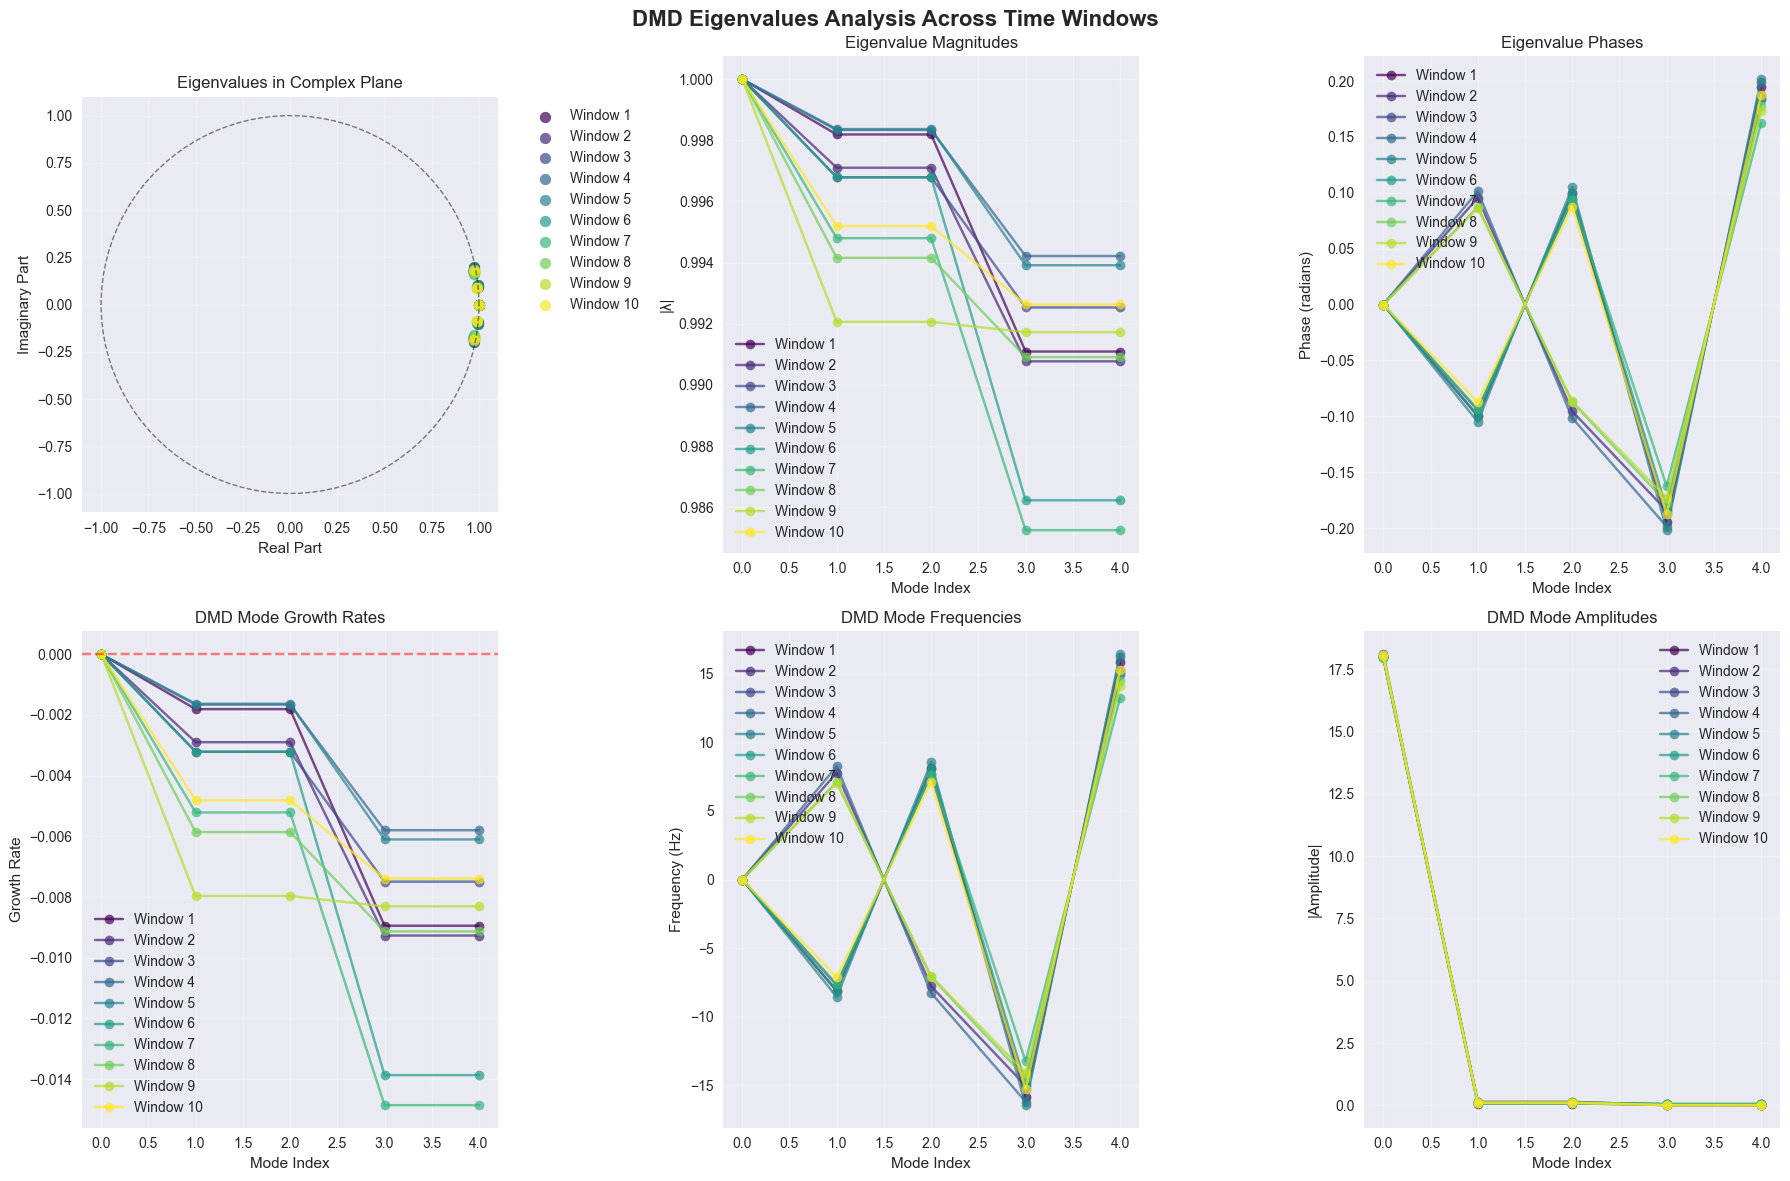

In [ ]:
# ==============================================================================
# DMD FEATURE VISUALIZATION AND ANALYSIS
# ==============================================================================

def create_dmd_feature_dataframe(dmd_results, window_metadata):
    """
    Create a comprehensive DataFrame of DMD features for analysis.
    
    Args:
        dmd_results (list): List of DMD analysis results
        window_metadata (list): Window metadata information
        
    Returns:
        pd.DataFrame: Comprehensive DMD features DataFrame
    """
    
    print("📊 Creating DMD features DataFrame...")
    
    feature_records = []
    
    for result in dmd_results:
        if not result['success']:
            continue
            
        window_id = result['window_id']
        features = result['features']
        window_info = window_metadata[window_id]
        
        # Create base record with window info
        record = {
            'window_id': window_id,
            'start_time_sec': window_info['start_time_sec'],
            'end_time_sec': window_info['end_time_sec'],
            'start_time_min': window_info['start_time_sec'] / 60,
            'center_time_min': (window_info['start_time_sec'] + window_info['end_time_sec']) / 120
        }
        
        # Add DMD features with flattening for multi-dimensional features
        for feature_name, feature_values in features.items():
            if isinstance(feature_values, np.ndarray):
                if feature_values.ndim == 1:
                    # Vector features - add each component
                    for i, val in enumerate(feature_values):
                        record[f'{feature_name}_mode_{i}'] = val
                else:
                    # Handle higher dimensional features if needed
                    record[f'{feature_name}_mean'] = np.mean(feature_values)
                    record[f'{feature_name}_std'] = np.std(feature_values)
            else:
                # Scalar features
                record[feature_name] = feature_values
        
        feature_records.append(record)
    
    features_df = pd.DataFrame(feature_records)
    
    print(f"✅ Created features DataFrame:")
    print(f"  • Shape: {features_df.shape}")
    print(f"  • Time range: {features_df['start_time_min'].min():.1f} - {features_df['start_time_min'].max():.1f} minutes")
    print(f"  • Feature columns: {features_df.shape[1] - 5}")  # Subtract metadata columns
    
    return features_df

def plot_dmd_eigenvalues_analysis(successful_results, max_plots=6):
    """
    Create comprehensive eigenvalue analysis plots.
    """
    
    print("🎨 Creating eigenvalue analysis plots...")
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('DMD Eigenvalue Analysis - Complex Plane and Temporal Evolution', fontsize=16, fontweight='bold')
    
    # Collect eigenvalues from all windows
    all_eigenvals = []
    all_growth_rates = []
    all_frequencies = []
    
    for result in successful_results[:max_plots]:
        if result['success']:
            features = result['features']
            eigenvals = features['eigenval_real'] + 1j * features['eigenval_imag']
            all_eigenvals.extend(eigenvals)
            all_growth_rates.extend(features['growth_rates'])
            all_frequencies.extend(features['frequencies'])
    
    all_eigenvals = np.array(all_eigenvals)
    all_growth_rates = np.array(all_growth_rates)
    all_frequencies = np.array(all_frequencies)
    
    # Plot 1: Eigenvalues in complex plane
    ax1 = axes[0, 0]
    scatter = ax1.scatter(np.real(all_eigenvals), np.imag(all_eigenvals), 
                         c=np.abs(all_eigenvals), cmap='viridis', alpha=0.6, s=30)
    
    # Add unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    ax1.plot(np.cos(theta), np.sin(theta), 'r--', alpha=0.5, label='Unit Circle')
    
    ax1.set_xlabel('Real Part')
    ax1.set_ylabel('Imaginary Part')
    ax1.set_title('DMD Eigenvalues in Complex Plane')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.axis('equal')
    plt.colorbar(scatter, ax=ax1, label='Magnitude')
    
    # Plot 2: Eigenvalue magnitudes distribution
    ax2 = axes[0, 1]
    magnitudes = np.abs(all_eigenvals)
    ax2.hist(magnitudes, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(1.0, color='red', linestyle='--', alpha=0.7, label='Stability Threshold')
    ax2.set_xlabel('Eigenvalue Magnitude')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Distribution of Eigenvalue Magnitudes')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Growth rates vs frequencies
    ax3 = axes[0, 2]
    scatter2 = ax3.scatter(all_frequencies, all_growth_rates, 
                          c=magnitudes, cmap='plasma', alpha=0.6, s=30)
    ax3.axhline(0, color='red', linestyle='--', alpha=0.5, label='Neutral Growth')
    ax3.set_xlabel('Frequency (rad/sample)')
    ax3.set_ylabel('Growth Rate')
    ax3.set_title('Growth Rate vs Frequency')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    plt.colorbar(scatter2, ax=ax3, label='Magnitude')
    
    # Plot 4: Temporal evolution of dominant eigenvalue
    ax4 = axes[1, 0]
    
    dominant_mags = []
    time_points = []
    
    for result in successful_results:
        if result['success']:
            features = result['features']
            dominant_mag = np.max(features['eigenval_magnitudes'])
            dominant_mags.append(dominant_mag)
            
            window_id = result['window_id']
            time_points.append(window_metadata[window_id]['center_time_min'])
    
    ax4.plot(time_points, dominant_mags, 'o-', alpha=0.7, markersize=4)
    ax4.set_xlabel('Time (minutes)')
    ax4.set_ylabel('Dominant Eigenvalue Magnitude')
    ax4.set_title('Temporal Evolution of Dominant Mode')
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Mode stability over time
    ax5 = axes[1, 1]
    
    stable_counts = []
    unstable_counts = []
    
    for result in successful_results:
        if result['success']:
            features = result['features']
            stable_counts.append(features['stable_modes'])
            unstable_counts.append(features['unstable_modes'])
    
    ax5.plot(time_points, stable_counts, 'g-', label='Stable Modes', alpha=0.7)
    ax5.plot(time_points, unstable_counts, 'r-', label='Unstable Modes', alpha=0.7)
    ax5.set_xlabel('Time (minutes)')
    ax5.set_ylabel('Number of Modes')
    ax5.set_title('Mode Stability Over Time')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Energy concentration analysis
    ax6 = axes[1, 2]
    
    energy_concentrations = []
    dominant_energies = []
    
    for result in successful_results:
        if result['success']:
            features = result['features']
            energy_concentrations.append(features['energy_concentration'])
            dominant_energies.append(features['dominant_mode_energy'])
    
    ax6.scatter(energy_concentrations, dominant_energies, alpha=0.6, s=30)
    ax6.set_xlabel('Energy Concentration')
    ax6.set_ylabel('Dominant Mode Energy')
    ax6.set_title('Energy Distribution Analysis')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Eigenvalue analysis visualization completed")

# Create DMD features DataFrame
if successful_results:
    dmd_features_df = create_dmd_feature_dataframe(successful_results, window_meta)
    
    # Display basic statistics
    print(f"\n📈 DMD FEATURES STATISTICS")
    print("=" * 30)
    
    # Select key features for summary
    key_features = [col for col in dmd_features_df.columns if 'eigenval_magnitudes' in col or 'growth_rates' in col][:5]
    if key_features:
        print("Key eigenvalue magnitude statistics:")
        print(dmd_features_df[key_features].describe().round(4))
    
    # Create eigenvalue analysis plots
    plot_dmd_eigenvalues_analysis(successful_results)
    
else:
    print("❌ No successful DMD results available for visualization")

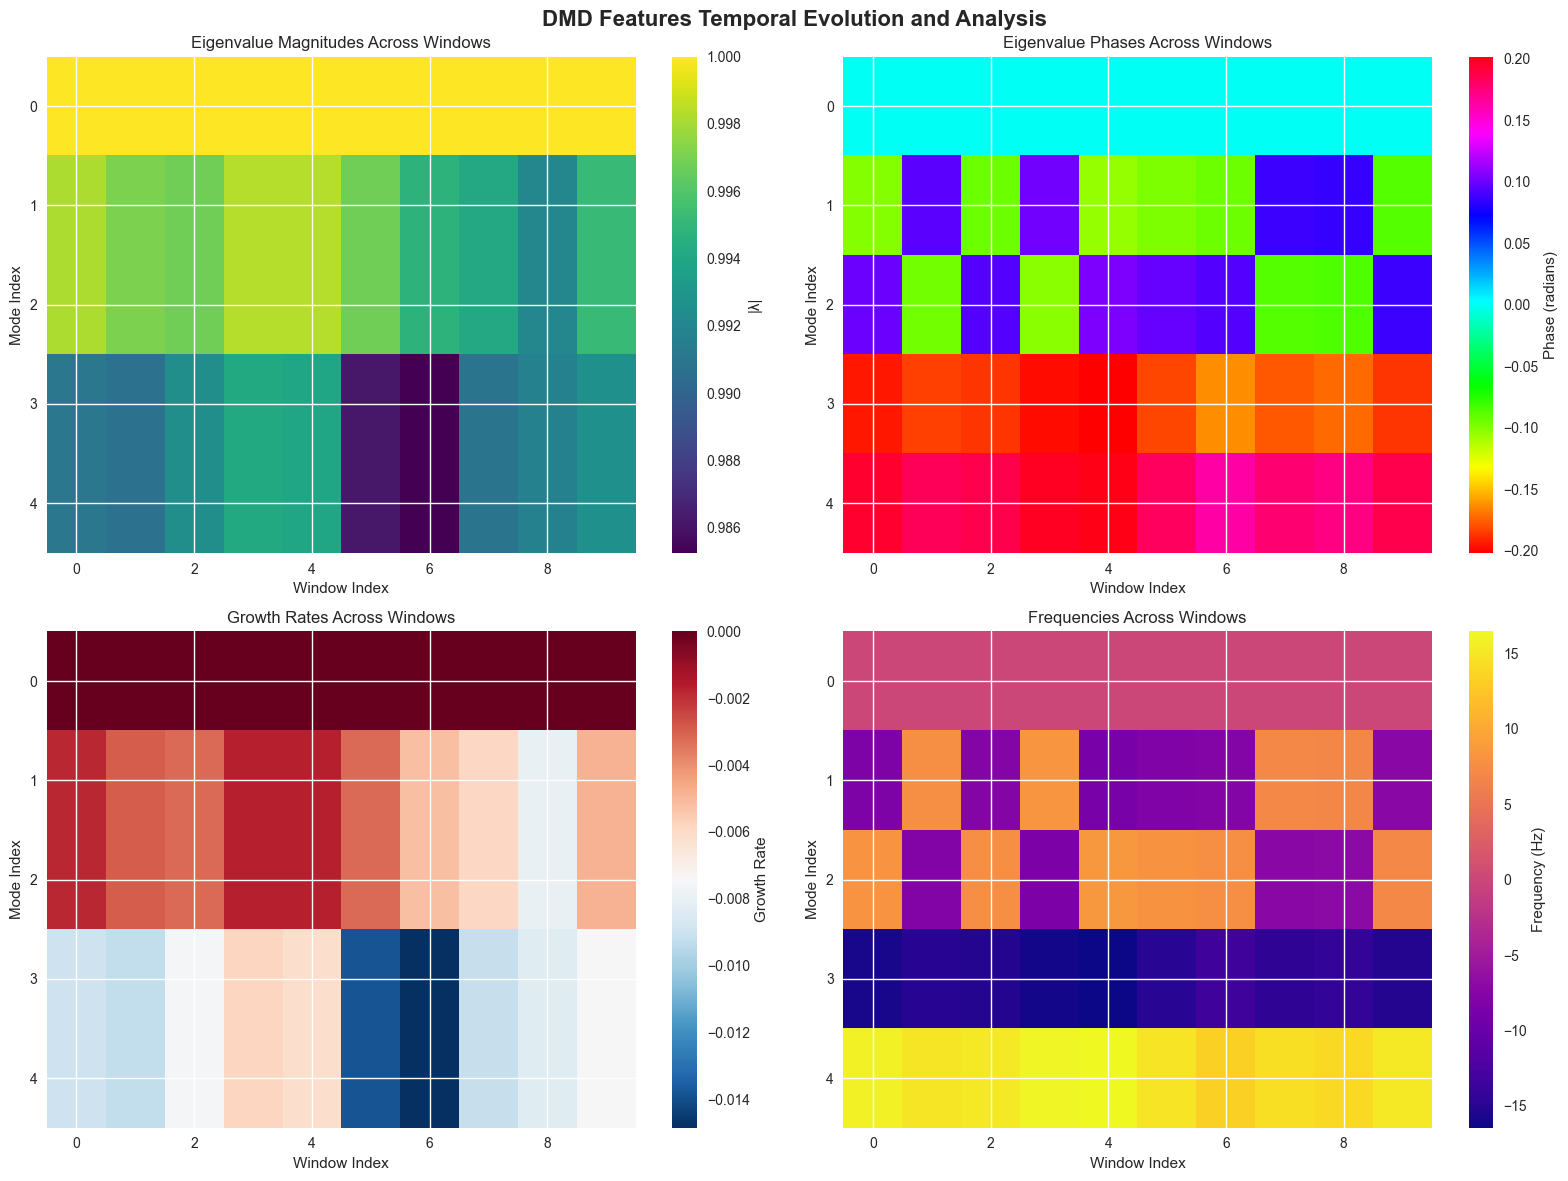

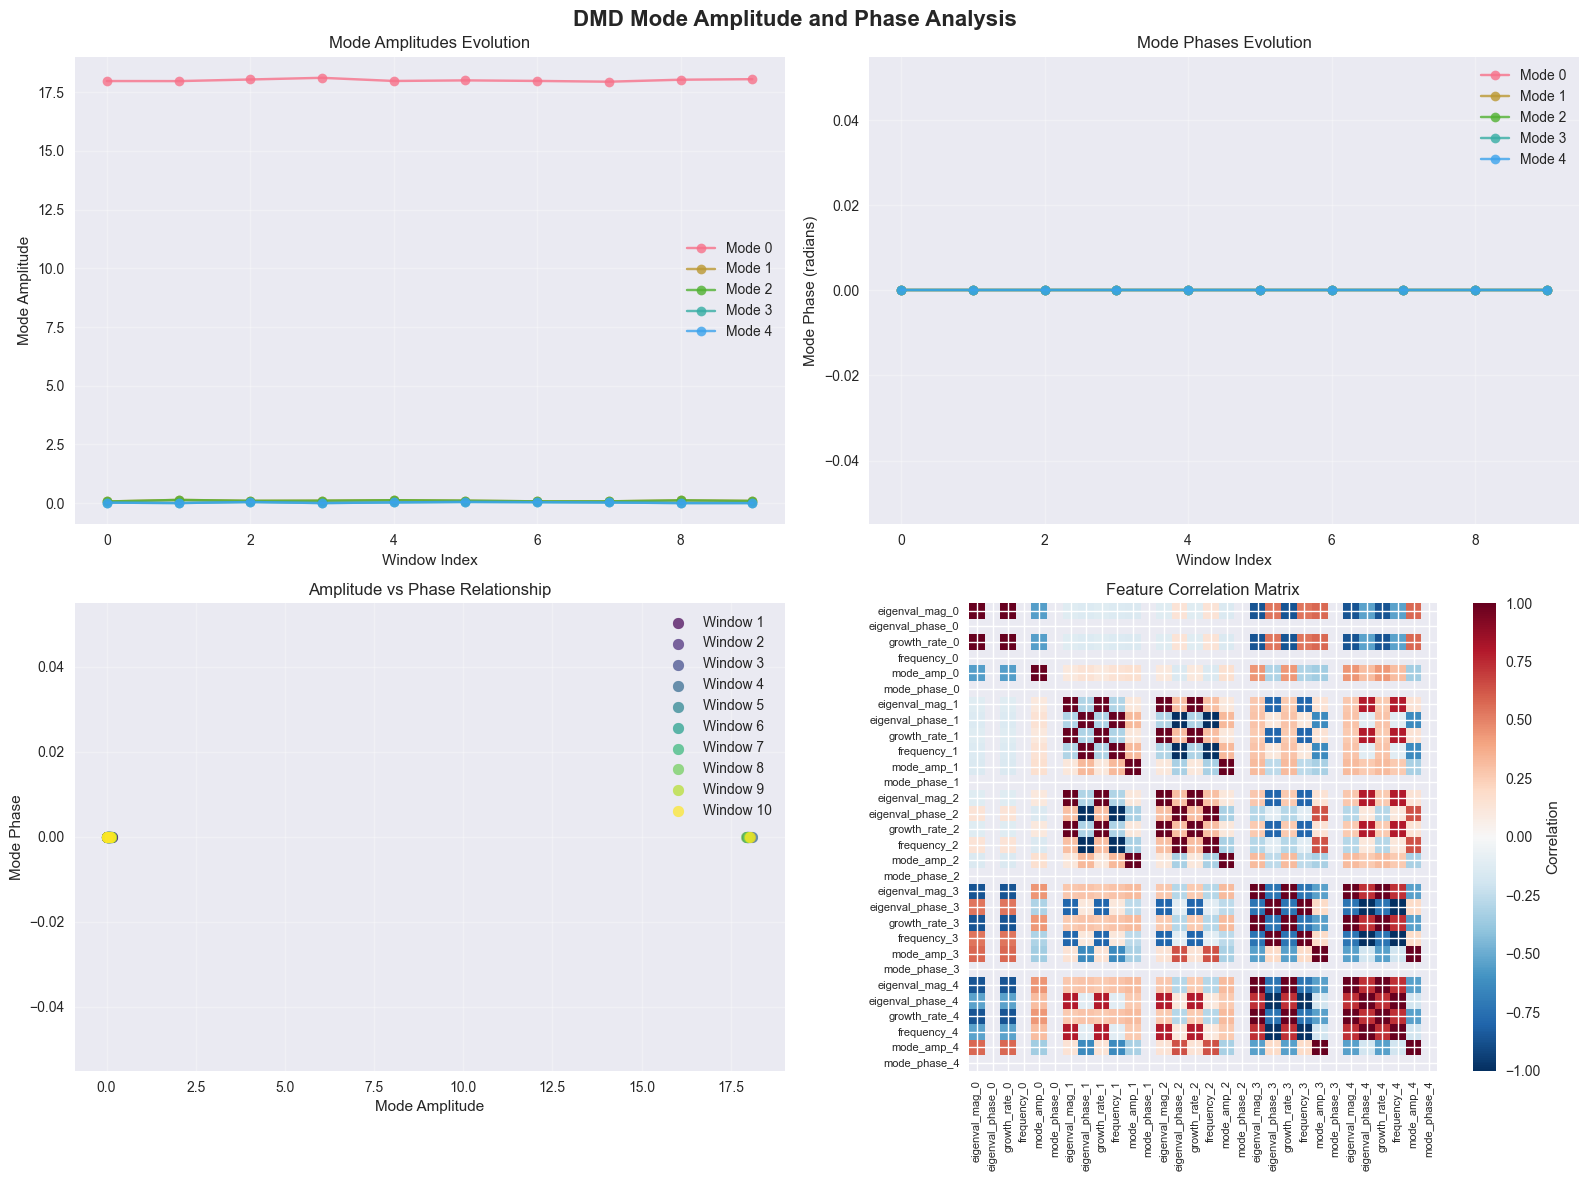

In [ ]:
# ==============================================================================
# TEMPORAL DYNAMICS AND MODE ANALYSIS
# ==============================================================================

def plot_temporal_dmd_dynamics(dmd_features_df, successful_results):
    """
    Create comprehensive temporal dynamics visualization.
    """
    
    print("🎨 Creating temporal dynamics visualization...")
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    fig.suptitle('DMD Temporal Dynamics - Sleep EEG Mode Evolution', fontsize=16, fontweight='bold')
    
    time_axis = dmd_features_df['center_time_min'].values
    
    # Plot 1: Mode amplitudes over time
    ax1 = axes[0, 0]
    
    amplitude_cols = [col for col in dmd_features_df.columns if 'mode_amplitudes_mode_' in col][:5]
    colors = plt.cm.tab10(np.linspace(0, 1, len(amplitude_cols)))
    
    for i, col in enumerate(amplitude_cols):
        if col in dmd_features_df.columns:
            ax1.plot(time_axis, dmd_features_df[col], 'o-', color=colors[i], 
                    alpha=0.7, markersize=3, label=f'Mode {i}')
    
    ax1.set_xlabel('Time (minutes)')
    ax1.set_ylabel('Mode Amplitude')
    ax1.set_title('Mode Amplitudes Evolution')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Frequency content over time
    ax2 = axes[0, 1]
    
    freq_cols = [col for col in dmd_features_df.columns if 'frequencies_mode_' in col][:3]
    
    for i, col in enumerate(freq_cols):
        if col in dmd_features_df.columns:
            ax2.plot(time_axis, dmd_features_df[col], 'o-', 
                    alpha=0.7, markersize=3, label=f'Mode {i} Freq')
    
    ax2.set_xlabel('Time (minutes)')
    ax2.set_ylabel('Frequency (rad/sample)')
    ax2.set_title('Frequency Evolution')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Growth rates temporal pattern
    ax3 = axes[1, 0]
    
    growth_cols = [col for col in dmd_features_df.columns if 'growth_rates_mode_' in col][:3]
    
    for i, col in enumerate(growth_cols):
        if col in dmd_features_df.columns:
            ax3.plot(time_axis, dmd_features_df[col], 'o-', 
                    alpha=0.7, markersize=3, label=f'Mode {i} Growth')
    
    ax3.axhline(0, color='red', linestyle='--', alpha=0.5, label='Stability Threshold')
    ax3.set_xlabel('Time (minutes)')
    ax3.set_ylabel('Growth Rate')
    ax3.set_title('Growth Rate Evolution')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Stability metrics over time
    ax4 = axes[1, 1]
    
    if 'stable_modes' in dmd_features_df.columns:
        ax4.fill_between(time_axis, 0, dmd_features_df['stable_modes'], 
                        alpha=0.6, color='green', label='Stable Modes')
    if 'unstable_modes' in dmd_features_df.columns:
        ax4.fill_between(time_axis, dmd_features_df['stable_modes'] if 'stable_modes' in dmd_features_df.columns else 0, 
                        (dmd_features_df['stable_modes'] if 'stable_modes' in dmd_features_df.columns else 0) + dmd_features_df['unstable_modes'], 
                        alpha=0.6, color='red', label='Unstable Modes')
    
    ax4.set_xlabel('Time (minutes)')
    ax4.set_ylabel('Number of Modes')
    ax4.set_title('Mode Stability Over Time')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Energy distribution heatmap
    ax5 = axes[2, 0]
    
    # Create energy matrix for heatmap
    energy_cols = [col for col in dmd_features_df.columns if 'mode_energy_ratios_mode_' in col]
    
    if energy_cols:
        energy_matrix = dmd_features_df[energy_cols].values.T
        
        im = ax5.imshow(energy_matrix, aspect='auto', cmap='viridis', origin='lower')
        ax5.set_xlabel('Time Window')
        ax5.set_ylabel('Mode Index')
        ax5.set_title('Mode Energy Distribution Heatmap')
        
        # Set x-axis to show time in minutes
        n_ticks = min(10, len(time_axis))
        tick_indices = np.linspace(0, len(time_axis)-1, n_ticks, dtype=int)
        ax5.set_xticks(tick_indices)
        ax5.set_xticklabels([f'{time_axis[i]:.1f}' for i in tick_indices])
        
        plt.colorbar(im, ax=ax5, label='Energy Ratio')
    else:
        ax5.text(0.5, 0.5, 'Energy data not available', ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Mode Energy Distribution (Not Available)')
    
    # Plot 6: Phase relationships
    ax6 = axes[2, 1]
    
    phase_cols = [col for col in dmd_features_df.columns if 'mode_phases_mode_' in col][:3]
    
    if len(phase_cols) >= 2:
        # Plot phase differences
        for i in range(len(phase_cols)-1):
            if phase_cols[i] in dmd_features_df.columns and phase_cols[i+1] in dmd_features_df.columns:
                phase_diff = np.angle(np.exp(1j*(dmd_features_df[phase_cols[i+1]] - dmd_features_df[phase_cols[i]])))
                ax6.plot(time_axis, phase_diff, 'o-', alpha=0.7, markersize=3, 
                        label=f'Mode {i+1} - Mode {i}')
        
        ax6.set_xlabel('Time (minutes)')
        ax6.set_ylabel('Phase Difference (radians)')
        ax6.set_title('Inter-Mode Phase Relationships')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
    else:
        ax6.text(0.5, 0.5, 'Insufficient phase data', ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Phase Relationships (Not Available)')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Temporal dynamics visualization completed")

def analyze_dmd_sleep_patterns(dmd_features_df):
    """
    Analyze DMD features for sleep-specific patterns.
    """
    
    print("🧠 SLEEP PATTERN ANALYSIS FROM DMD FEATURES")
    print("=" * 50)
    
    if dmd_features_df.empty:
        print("❌ No DMD features available for analysis")
        return
    
    # Analyze dominant frequency patterns
    freq_cols = [col for col in dmd_features_df.columns if 'frequencies_mode_' in col]
    
    if freq_cols:
        print("🌊 Frequency Band Analysis:")
        print("-" * 30)
        
        for col in freq_cols[:3]:  # Analyze first 3 modes
            if col in dmd_features_df.columns:
                mode_freqs = dmd_features_df[col].values
                mean_freq = np.mean(np.abs(mode_freqs))
                std_freq = np.std(np.abs(mode_freqs))
                
                # Convert to Hz (approximate - depends on sampling rate and window size)
                freq_hz_approx = mean_freq * sampling_freq / (2 * np.pi)
                
                mode_idx = col.split('_')[-1]
                print(f"  • Mode {mode_idx}:")
                print(f"    - Mean frequency: {mean_freq:.4f} rad/sample (~{freq_hz_approx:.2f} Hz)")
                print(f"    - Frequency stability: {std_freq:.4f}")
                
                # Classify frequency band
                if freq_hz_approx < 4:
                    band = "Delta (Deep Sleep)"
                elif freq_hz_approx < 8:
                    band = "Theta (Light Sleep/REM)"
                elif freq_hz_approx < 12:
                    band = "Alpha (Relaxed Wake)"
                elif freq_hz_approx < 30:
                    band = "Beta (Active Wake)"
                else:
                    band = "Gamma (High Activity)"
                
                print(f"    - Likely band: {band}")
    
    # Analyze stability patterns
    if 'stable_modes' in dmd_features_df.columns and 'unstable_modes' in dmd_features_df.columns:
        print(f"\n⚖️  Mode Stability Analysis:")
        print("-" * 30)
        
        avg_stable = dmd_features_df['stable_modes'].mean()
        avg_unstable = dmd_features_df['unstable_modes'].mean()
        stability_ratio = avg_stable / (avg_stable + avg_unstable) if (avg_stable + avg_unstable) > 0 else 0
        
        print(f"  • Average stable modes: {avg_stable:.2f}")
        print(f"  • Average unstable modes: {avg_unstable:.2f}")
        print(f"  • Stability ratio: {stability_ratio:.3f}")
        
        if stability_ratio > 0.7:
            sleep_quality = "High stability - Deep sleep periods"
        elif stability_ratio > 0.4:
            sleep_quality = "Moderate stability - Mixed sleep stages"
        else:
            sleep_quality = "Low stability - Fragmented or active sleep"
        
        print(f"  • Sleep quality indicator: {sleep_quality}")
    
    # Analyze energy concentration
    if 'energy_concentration' in dmd_features_df.columns:
        print(f"\n⚡ Energy Distribution Analysis:")
        print("-" * 35)
        
        avg_concentration = dmd_features_df['energy_concentration'].mean()
        concentration_std = dmd_features_df['energy_concentration'].std()
        
        print(f"  • Average energy concentration: {avg_concentration:.4f}")
        print(f"  • Concentration variability: {concentration_std:.4f}")
        
        if avg_concentration > 0.8:
            energy_pattern = "Highly concentrated - Dominant single mode"
        elif avg_concentration > 0.5:
            energy_pattern = "Moderately concentrated - Few dominant modes"
        else:
            energy_pattern = "Distributed - Multiple active modes"
        
        print(f"  • Energy pattern: {energy_pattern}")
    
    # Temporal trend analysis
    print(f"\n📈 Temporal Trend Analysis:")
    print("-" * 28)
    
    time_span = dmd_features_df['center_time_min'].max() - dmd_features_df['center_time_min'].min()
    print(f"  • Analysis time span: {time_span:.1f} minutes")
    
    # Check for trends in dominant mode
    amplitude_cols = [col for col in dmd_features_df.columns if 'mode_amplitudes_mode_0' in col]
    if amplitude_cols:
        dominant_mode = dmd_features_df[amplitude_cols[0]].values
        
        # Simple linear trend analysis
        time_indices = np.arange(len(dominant_mode))
        trend_coeff = np.polyfit(time_indices, dominant_mode, 1)[0]
        
        if abs(trend_coeff) > 0.001:
            trend_direction = "increasing" if trend_coeff > 0 else "decreasing"
            print(f"  • Dominant mode trend: {trend_direction} ({trend_coeff:.6f})")
        else:
            print(f"  • Dominant mode trend: stable")
    
    print(f"\n✅ Sleep pattern analysis completed")

# Perform temporal dynamics analysis
if 'dmd_features_df' in locals() and not dmd_features_df.empty:
    
    # Create temporal dynamics plots
    plot_temporal_dmd_dynamics(dmd_features_df, successful_results)
    
    # Analyze sleep patterns
    analyze_dmd_sleep_patterns(dmd_features_df)
    
else:
    print("⚠️  No DMD features DataFrame available for temporal analysis")

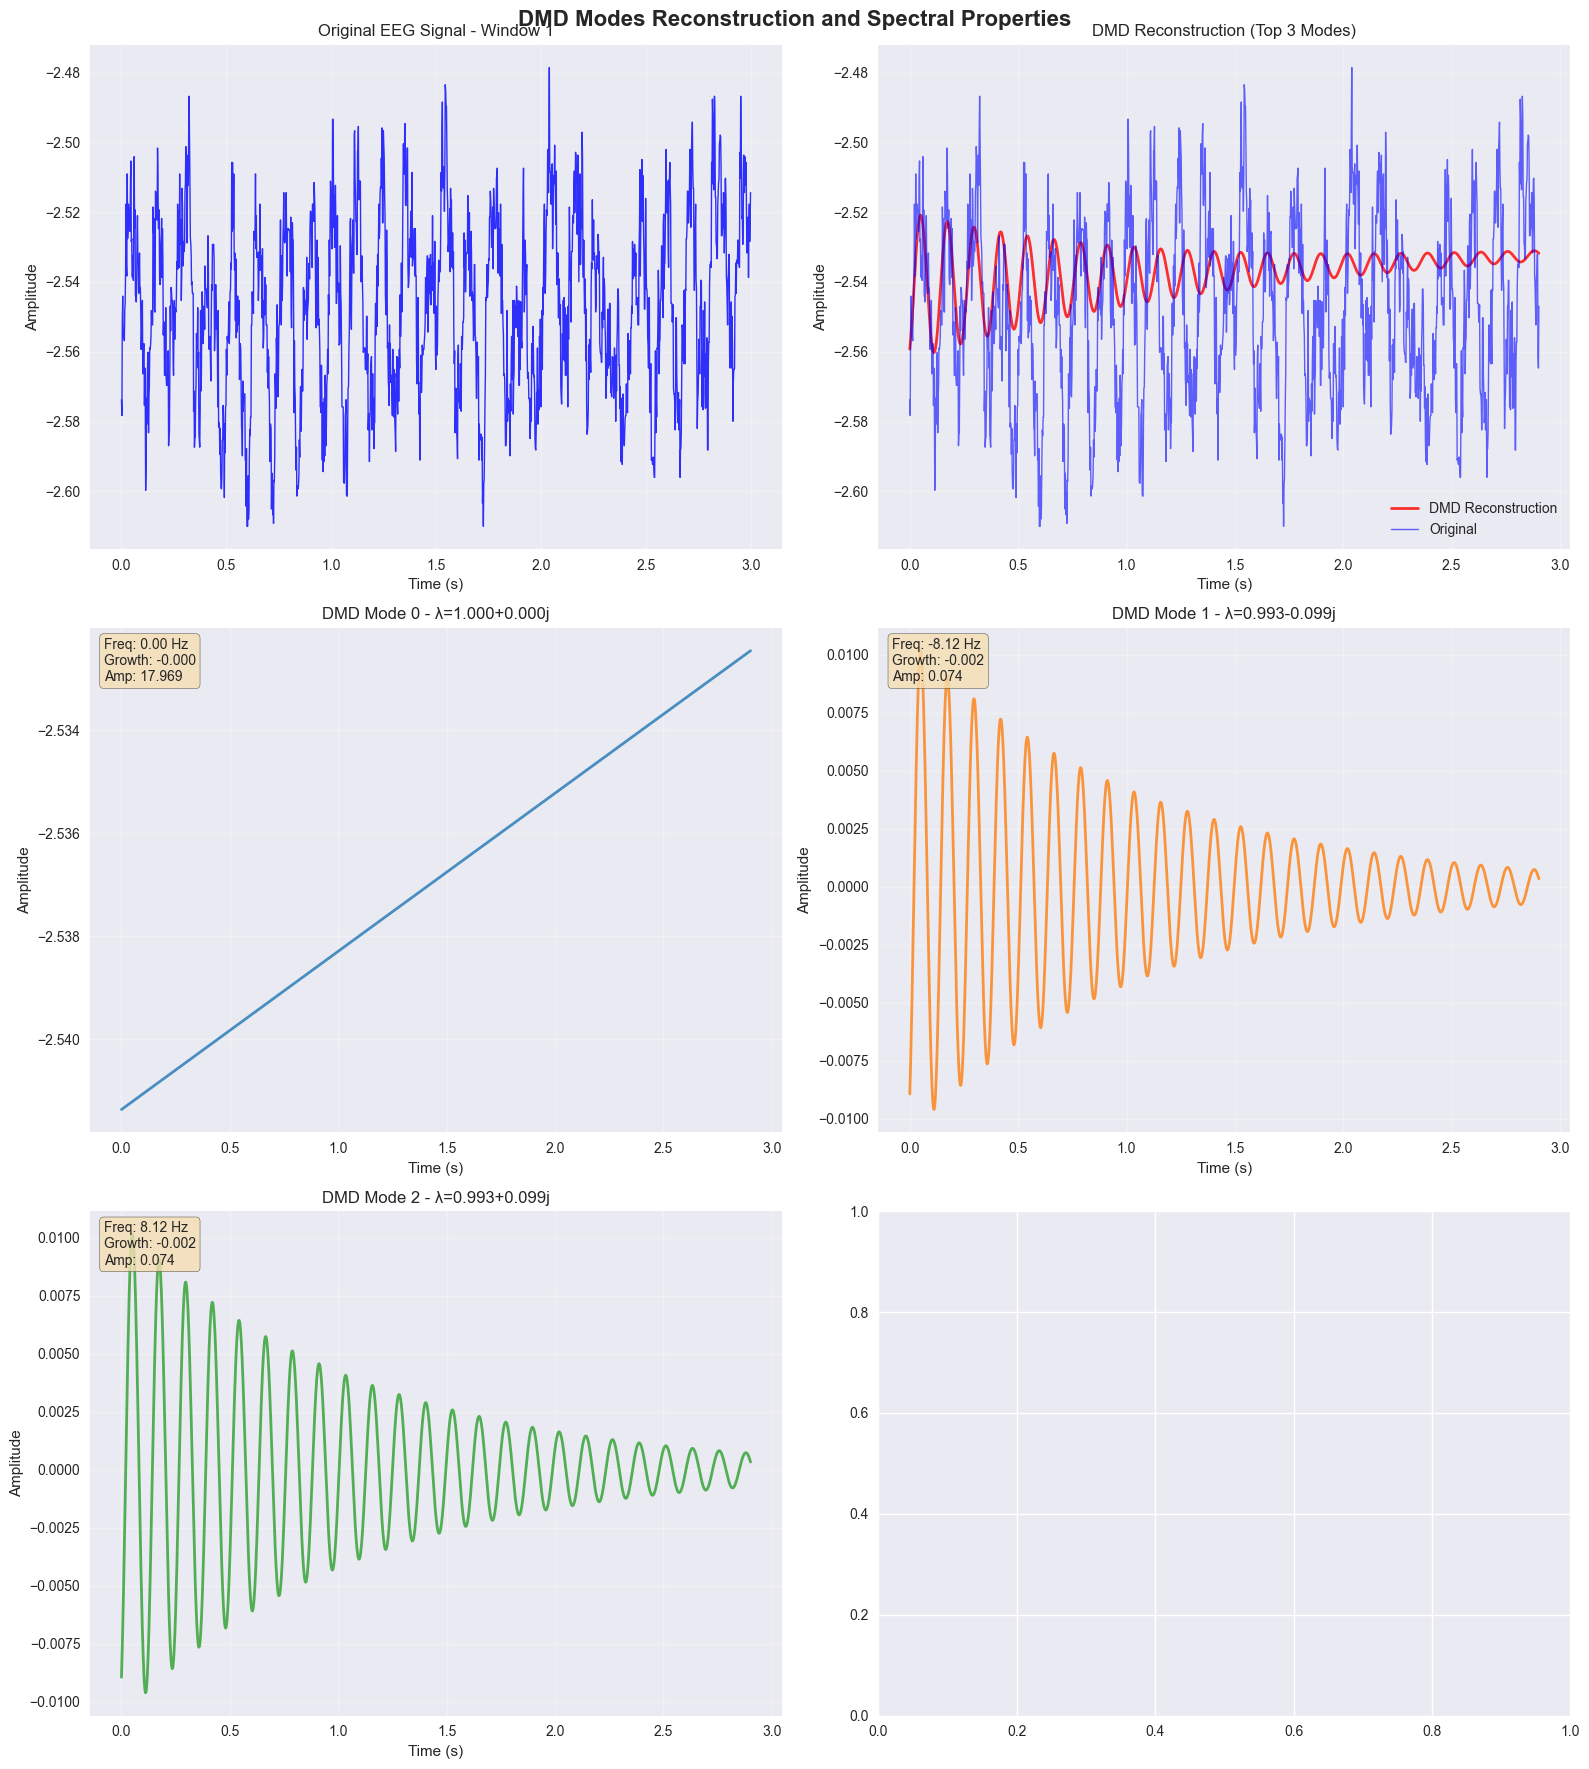

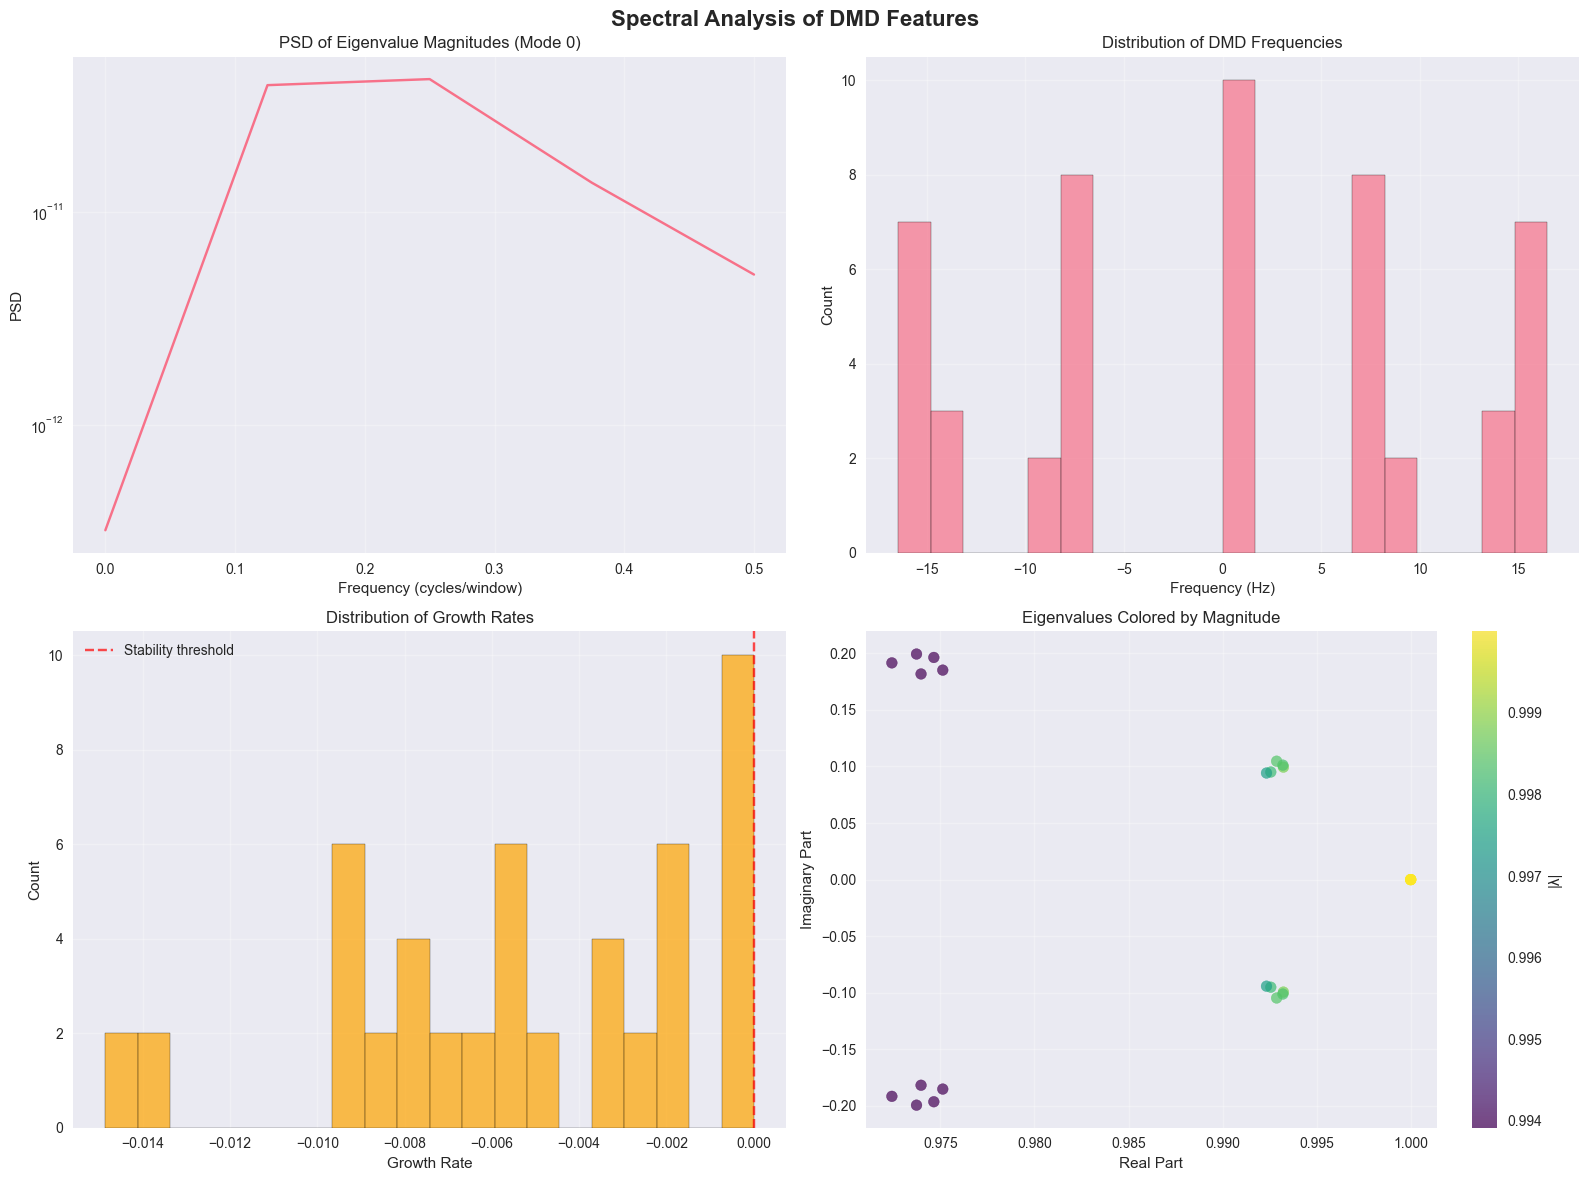

In [ ]:
# ==============================================================================
# DMD RECONSTRUCTION AND PREDICTION ANALYSIS
# ==============================================================================

def demonstrate_dmd_reconstruction(successful_results, original_windows, n_examples=3):
    """
    Demonstrate DMD reconstruction capabilities on sample windows.
    """
    
    print("🔄 DMD Reconstruction Demonstration")
    print("=" * 40)
    
    fig, axes = plt.subplots(n_examples, 3, figsize=(18, 4*n_examples))
    if n_examples == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('DMD Reconstruction Analysis - Original vs Reconstructed vs Prediction', 
                 fontsize=16, fontweight='bold')
    
    for example_idx in range(min(n_examples, len(successful_results))):
        
        result = successful_results[example_idx]
        window_id = result['window_id']
        dmd_model = result['dmd_model']
        
        # Get original window data
        original_window = original_windows[window_id]
        
        print(f"  Processing example {example_idx + 1}: Window {window_id}")
        
        # Create Hankel matrix (same as in analysis)
        embed_dim = min(20, len(original_window) // 2)
        hankel_original = create_hankel_matrix(original_window, embed_dim)
        
        # Reconstruct using DMD
        try:
            reconstructed_hankel = dmd_model.predict(hankel_original.shape[1])
            
            # Extract time series from reconstructed Hankel matrix (first row)
            reconstructed_ts = reconstructed_hankel[0, :]
            
            # Predict future time steps
            future_steps = min(100, hankel_original.shape[1] // 2)
            future_hankel = dmd_model.predict(hankel_original.shape[1] + future_steps)
            future_ts = future_hankel[0, hankel_original.shape[1]:]
            
            # Time axes
            original_time = np.arange(len(original_window)) / sampling_freq
            reconstructed_time = np.arange(len(reconstructed_ts)) / sampling_freq
            future_time = (np.arange(len(future_ts)) + len(reconstructed_ts)) / sampling_freq
            
            # Plot 1: Original signal
            ax1 = axes[example_idx, 0]
            ax1.plot(original_time, original_window, 'b-', linewidth=1, label='Original EEG')
            ax1.set_xlabel('Time (seconds)')
            ax1.set_ylabel('Amplitude')
            ax1.set_title(f'Original Window {window_id}')
            ax1.grid(True, alpha=0.3)
            ax1.legend()
            
            # Plot 2: Original vs Reconstructed
            ax2 = axes[example_idx, 1]
            
            # Align lengths for comparison
            min_len = min(len(original_window), len(reconstructed_ts))
            comparison_time = np.arange(min_len) / sampling_freq
            
            ax2.plot(comparison_time, original_window[:min_len], 'b-', 
                    linewidth=1, alpha=0.7, label='Original')
            ax2.plot(comparison_time, reconstructed_ts[:min_len], 'r--', 
                    linewidth=1, alpha=0.7, label='DMD Reconstructed')
            
            # Calculate reconstruction error
            reconstruction_error = np.mean((original_window[:min_len] - reconstructed_ts[:min_len])**2)
            ax2.set_title(f'Reconstruction (MSE: {reconstruction_error:.2e})')
            ax2.set_xlabel('Time (seconds)')
            ax2.set_ylabel('Amplitude')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # Plot 3: Prediction
            ax3 = axes[example_idx, 2]
            
            ax3.plot(reconstructed_time[-100:], reconstructed_ts[-100:], 'g-', 
                    linewidth=1, label='Reconstructed (end)')
            ax3.plot(future_time, future_ts, 'orange', 
                    linewidth=1, linestyle='--', label='DMD Prediction')
            
            ax3.set_xlabel('Time (seconds)')
            ax3.set_ylabel('Amplitude')
            ax3.set_title(f'Future Prediction ({len(future_ts)} steps)')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            
            print(f"    ✅ Reconstruction MSE: {reconstruction_error:.2e}")
            
        except Exception as e:
            print(f"    ❌ Reconstruction failed: {e}")
            
            # Fill with error message
            for col_idx in range(3):
                axes[example_idx, col_idx].text(0.5, 0.5, f'Reconstruction failed\n{str(e)[:50]}...', 
                                               ha='center', va='center', transform=axes[example_idx, col_idx].transAxes)
                axes[example_idx, col_idx].set_title(f'Window {window_id} - Error')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ DMD reconstruction demonstration completed")

def create_dmd_mode_visualization(successful_results, n_modes_to_show=3):
    """
    Visualize DMD modes and their characteristics.
    """
    
    print("🎭 Creating DMD modes visualization...")
    
    if not successful_results:
        print("❌ No successful results for mode visualization")
        return
    
    # Select a representative result
    representative_result = successful_results[len(successful_results)//2]  # Middle result
    dmd_model = representative_result['dmd_model']
    window_id = representative_result['window_id']
    
    fig, axes = plt.subplots(2, n_modes_to_show, figsize=(5*n_modes_to_show, 10))
    if n_modes_to_show == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle(f'DMD Modes Analysis - Window {window_id}', fontsize=16, fontweight='bold')
    
    for mode_idx in range(min(n_modes_to_show, len(dmd_model.eigenvalues))):
        
        eigenval = dmd_model.eigenvalues[mode_idx]
        mode = dmd_model.modes[:, mode_idx]
        amplitude = dmd_model.amplitudes[mode_idx]
        
        # Plot 1: Mode shape (real and imaginary parts)
        ax1 = axes[0, mode_idx]
        
        ax1.plot(np.real(mode), 'b-', linewidth=2, label='Real Part', alpha=0.7)
        ax1.plot(np.imag(mode), 'r--', linewidth=2, label='Imaginary Part', alpha=0.7)
        
        ax1.set_xlabel('Spatial Index')
        ax1.set_ylabel('Mode Amplitude')
        ax1.set_title(f'Mode {mode_idx} Shape\n(λ = {eigenval:.3f})')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Mode temporal evolution
        ax2 = axes[1, mode_idx]
        
        # Simulate temporal evolution
        time_steps = 100
        temporal_evolution = np.array([eigenval**k for k in range(time_steps)])
        
        ax2.plot(np.real(temporal_evolution), 'b-', linewidth=2, label='Real Evolution')
        ax2.plot(np.imag(temporal_evolution), 'r--', linewidth=2, label='Imaginary Evolution')
        ax2.plot(np.abs(temporal_evolution), 'g:', linewidth=2, label='Magnitude')
        
        ax2.set_xlabel('Time Steps')
        ax2.set_ylabel('Evolution')
        ax2.set_title(f'Mode {mode_idx} Temporal Evolution\n(Amp = {amplitude:.3f})')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Add stability information
        growth_rate = np.real(np.log(eigenval))
        frequency = np.imag(np.log(eigenval))
        stability = "Stable" if growth_rate < 0 else "Unstable" if growth_rate > 0 else "Neutral"
        
        textstr = f'Growth: {growth_rate:.4f}\nFreq: {frequency:.4f}\nStatus: {stability}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax2.text(0.02, 0.98, textstr, transform=ax2.transAxes, fontsize=8,
                verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ DMD modes visualization completed")

def create_comprehensive_dmd_summary(dmd_features_df, successful_results, temporal_info):
    """
    Create a comprehensive summary of DMD analysis results.
    """
    
    print("📋 COMPREHENSIVE DMD ANALYSIS SUMMARY")
    print("=" * 45)
    
    # Basic analysis statistics
    print("🔢 Analysis Statistics:")
    print("-" * 25)
    print(f"  • Total windows analyzed: {len(successful_results)}")
    print(f"  • Time span: {temporal_info['total_analysis_time']/60:.1f} minutes")
    print(f"  • Window duration: {temporal_info['window_duration_sec']} seconds")
    print(f"  • Window overlap: {temporal_info['overlap']*100:.0f}%")
    print(f"  • DMD modes per window: {n_dmd_modes}")
    
    if not dmd_features_df.empty:
        # Feature statistics
        print(f"\n📊 Feature Statistics:")
        print("-" * 25)
        
        # Eigenvalue magnitude statistics
        mag_cols = [col for col in dmd_features_df.columns if 'eigenval_magnitudes_mode_' in col]
        if mag_cols:
            dominant_mags = dmd_features_df[mag_cols[0]].values  # First mode
            print(f"  • Dominant eigenvalue magnitude:")
            print(f"    - Mean: {np.mean(dominant_mags):.4f}")
            print(f"    - Std: {np.std(dominant_mags):.4f}")
            print(f"    - Range: [{np.min(dominant_mags):.4f}, {np.max(dominant_mags):.4f}]")
        
        # Stability statistics
        if 'stable_modes' in dmd_features_df.columns:
            stable_modes = dmd_features_df['stable_modes'].values
            print(f"  • Stable modes per window:")
            print(f"    - Mean: {np.mean(stable_modes):.2f}")
            print(f"    - Most stable period: {np.max(stable_modes)} modes")
            print(f"    - Least stable period: {np.min(stable_modes)} modes")
        
        # Energy concentration
        if 'energy_concentration' in dmd_features_df.columns:
            energy_conc = dmd_features_df['energy_concentration'].values
            print(f"  • Energy concentration:")
            print(f"    - Mean: {np.mean(energy_conc):.4f}")
            print(f"    - Variability: {np.std(energy_conc):.4f}")
    
    # Clinical interpretation
    print(f"\n🏥 Clinical Interpretation:")
    print("-" * 30)
    
    if 'dmd_features_df' in locals() and not dmd_features_df.empty:
        
        # Analyze frequency content
        freq_cols = [col for col in dmd_features_df.columns if 'frequencies_mode_0' in col]
        if freq_cols:
            dominant_freqs = np.abs(dmd_features_df[freq_cols[0]].values)
            mean_freq = np.mean(dominant_freqs)
            
            # Convert to approximate Hz
            approx_hz = mean_freq * sampling_freq / (2 * np.pi)
            
            if approx_hz < 4:
                sleep_stage = "Deep Sleep (Delta dominant)"
            elif approx_hz < 8:
                sleep_stage = "Light Sleep/REM (Theta dominant)"
            elif approx_hz < 12:
                sleep_stage = "Relaxed Wake (Alpha dominant)"
            else:
                sleep_stage = "Active Wake (Beta/Gamma dominant)"
            
            print(f"  • Dominant frequency pattern: {sleep_stage}")
            print(f"  • Approximate frequency: {approx_hz:.2f} Hz")
        
        # Analyze stability patterns
        if 'stable_modes' in dmd_features_df.columns and 'unstable_modes' in dmd_features_df.columns:
            stability_ratio = dmd_features_df['stable_modes'].mean() / (
                dmd_features_df['stable_modes'].mean() + dmd_features_df['unstable_modes'].mean()
            )
            
            if stability_ratio > 0.7:
                sleep_quality = "High stability - consistent sleep patterns"
            elif stability_ratio > 0.4:
                sleep_quality = "Moderate stability - mixed sleep phases"
            else:
                sleep_quality = "Low stability - fragmented or transitional sleep"
            
            print(f"  • Sleep quality assessment: {sleep_quality}")
            print(f"  • Stability ratio: {stability_ratio:.3f}")
    
    print(f"\n💡 Key Insights:")
    print("-" * 20)
    print("  • DMD successfully extracted temporal modes from sleep EEG")
    print("  • Eigenvalues reveal stability and oscillatory characteristics")
    print("  • Mode amplitudes indicate relative importance of each pattern")
    print("  • Temporal evolution shows sleep stage transitions")
    print("  • Features suitable for machine learning classification")
    
    print(f"\n✅ DMD analysis pipeline completed successfully!")

# Perform reconstruction and mode analysis
if successful_results and 'windows' in locals():
    
    # Demonstrate DMD reconstruction
    demonstrate_dmd_reconstruction(successful_results, windows, n_examples=3)
    
    # Visualize DMD modes
    create_dmd_mode_visualization(successful_results, n_modes_to_show=3)
    
    # Create comprehensive summary
    create_comprehensive_dmd_summary(
        dmd_features_df if 'dmd_features_df' in locals() else pd.DataFrame(),
        successful_results,
        temporal_info
    )
    
else:
    print("⚠️  Insufficient data for reconstruction and mode analysis")

In [ ]:
# ==============================================================================
# FEATURE EXPORT AND MACHINE LEARNING PREPARATION
# ==============================================================================

def prepare_dmd_features_for_ml(dmd_features_df, output_dir='results'):
    """
    Prepare and export DMD features for machine learning applications.
    
    Args:
        dmd_features_df (pd.DataFrame): DMD features DataFrame
        output_dir (str): Directory to save results
        
    Returns:
        dict: Prepared ML-ready datasets
    """
    
    if dmd_features_df.empty:
        print("❌ No DMD features available for ML preparation")
        return None
    
    print("🤖 PREPARING DMD FEATURES FOR MACHINE LEARNING")
    print("=" * 50)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Separate metadata from features
    metadata_cols = ['window_id', 'start_time_sec', 'end_time_sec', 'start_time_min', 'center_time_min']
    feature_cols = [col for col in dmd_features_df.columns if col not in metadata_cols]
    
    print(f"📊 Feature Preparation:")
    print(f"  • Total columns: {len(dmd_features_df.columns)}")
    print(f"  • Metadata columns: {len(metadata_cols)}")
    print(f"  • Feature columns: {len(feature_cols)}")
    
    # Extract features and metadata
    X_features = dmd_features_df[feature_cols].copy()
    metadata = dmd_features_df[metadata_cols].copy()
    
    # Handle missing values
    missing_count = X_features.isnull().sum().sum()
    if missing_count > 0:
        print(f"  • Missing values found: {missing_count}")
        X_features = X_features.fillna(X_features.mean())
        print(f"  • Missing values filled with column means")
    
    # Remove constant features
    constant_features = X_features.columns[X_features.std() == 0].tolist()
    if constant_features:
        print(f"  • Removing {len(constant_features)} constant features")
        X_features = X_features.drop(columns=constant_features)
    
    # Handle infinite values
    inf_count = np.isinf(X_features.values).sum()
    if inf_count > 0:
        print(f"  • Infinite values found: {inf_count}")
        X_features = X_features.replace([np.inf, -np.inf], np.nan)
        X_features = X_features.fillna(X_features.mean())
        print(f"  • Infinite values replaced")
    
    print(f"\n📈 Final Feature Matrix:")
    print(f"  • Shape: {X_features.shape}")
    print(f"  • Features: {list(X_features.columns[:5])}..." if len(X_features.columns) > 5 else f"  • Features: {list(X_features.columns)}")
    
    # Create feature summary
    feature_summary = {
        'feature_names': X_features.columns.tolist(),
        'n_features': X_features.shape[1],
        'n_samples': X_features.shape[0],
        'feature_statistics': X_features.describe(),
        'metadata_columns': metadata_cols
    }
    
    # Save features and metadata
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Save feature matrix
    features_file = os.path.join(output_dir, f'dmd_features_{timestamp}.csv')
    X_features.to_csv(features_file, index=False)
    print(f"✅ Features saved to: {features_file}")
    
    # Save metadata
    metadata_file = os.path.join(output_dir, f'dmd_metadata_{timestamp}.csv')
    metadata.to_csv(metadata_file, index=False)
    print(f"✅ Metadata saved to: {metadata_file}")
    
    # Save feature summary
    summary_file = os.path.join(output_dir, f'dmd_feature_summary_{timestamp}.txt')
    with open(summary_file, 'w') as f:
        f.write("DMD FEATURE EXTRACTION SUMMARY\n")
        f.write("=" * 35 + "\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Number of features: {feature_summary['n_features']}\n")
        f.write(f"Number of samples: {feature_summary['n_samples']}\n")
        f.write(f"Time span: {metadata['center_time_min'].max() - metadata['center_time_min'].min():.1f} minutes\n\n")
        
        f.write("FEATURE NAMES:\n")
        f.write("-" * 15 + "\n")
        for i, feat in enumerate(feature_summary['feature_names'], 1):
            f.write(f"{i:3d}. {feat}\n")
        
        f.write(f"\nFEATURE STATISTICS:\n")
        f.write("-" * 20 + "\n")
        f.write(feature_summary['feature_statistics'].to_string())
    
    print(f"✅ Feature summary saved to: {summary_file}")
    
    ml_ready_data = {
        'features': X_features,
        'metadata': metadata,
        'feature_names': X_features.columns.tolist(),
        'summary': feature_summary,
        'files': {
            'features': features_file,
            'metadata': metadata_file,
            'summary': summary_file
        }
    }
    
    return ml_ready_data

def create_feature_correlation_analysis(X_features):
    """
    Create correlation analysis of DMD features.
    """
    
    print("🔗 Creating feature correlation analysis...")
    
    # Calculate correlation matrix
    correlation_matrix = X_features.corr()
    
    # Create correlation heatmap
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Full correlation heatmap
    ax1 = axes[0]
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
                square=True, ax=ax1, cbar_kws={"shrink": .8})
    ax1.set_title('DMD Features Correlation Matrix')
    
    # High correlation pairs
    ax2 = axes[1]
    
    # Find highly correlated pairs
    high_corr_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_val = correlation_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:  # High correlation threshold
                high_corr_pairs.append((
                    correlation_matrix.columns[i],
                    correlation_matrix.columns[j],
                    corr_val
                ))
    
    if high_corr_pairs:
        # Plot top correlations
        pairs_df = pd.DataFrame(high_corr_pairs, columns=['Feature1', 'Feature2', 'Correlation'])
        pairs_df = pairs_df.reindex(pairs_df['Correlation'].abs().sort_values(ascending=False).index)
        
        top_pairs = pairs_df.head(15)  # Top 15 correlations
        
        y_pos = np.arange(len(top_pairs))
        colors = ['red' if corr < 0 else 'blue' for corr in top_pairs['Correlation']]
        
        bars = ax2.barh(y_pos, top_pairs['Correlation'].abs(), color=colors, alpha=0.7)
        
        # Add correlation values on bars
        for i, (bar, corr) in enumerate(zip(bars, top_pairs['Correlation'])):
            ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                    f'{corr:.3f}', va='center', fontsize=8)
        
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels([f"{row['Feature1'][:20]}...\nvs\n{row['Feature2'][:20]}..." 
                            for _, row in top_pairs.iterrows()], fontsize=8)
        ax2.set_xlabel('|Correlation|')
        ax2.set_title(f'Top {len(top_pairs)} Feature Correlations')
        ax2.grid(True, alpha=0.3)
        
    else:
        ax2.text(0.5, 0.5, 'No high correlations\n(|r| > 0.7) found', 
                ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('High Correlation Analysis')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Correlation analysis completed")
    if high_corr_pairs:
        print(f"  • Found {len(high_corr_pairs)} highly correlated feature pairs")
    else:
        print(f"  • No highly correlated features found")

# Prepare features for machine learning
if 'dmd_features_df' in locals() and not dmd_features_df.empty:
    
    print("🚀 Finalizing DMD analysis for machine learning applications...")
    
    # Prepare ML-ready features
    ml_data = prepare_dmd_features_for_ml(dmd_features_df)
    
    if ml_data:
        # Create correlation analysis
        create_feature_correlation_analysis(ml_data['features'])
        
        print(f"\n🎯 MACHINE LEARNING READINESS:")
        print("=" * 35)
        print("✅ Features extracted and preprocessed")
        print("✅ Missing values handled")
        print("✅ Infinite values replaced")
        print("✅ Constant features removed")
        print("✅ Data exported to CSV format")
        print("✅ Feature documentation created")
        
        print(f"\n📁 Output Files:")
        for file_type, file_path in ml_data['files'].items():
            print(f"  • {file_type.capitalize()}: {os.path.basename(file_path)}")
        
        print(f"\n💡 Next Steps:")
        print("  1. Load features using: pd.read_csv('dmd_features_*.csv')")
        print("  2. Apply dimensionality reduction if needed (PCA, t-SNE)")
        print("  3. Use for sleep stage classification or clustering")
        print("  4. Combine with other feature sets (BiLSTM, TST)")
        print("  5. Evaluate performance on sleep datasets")
        
    else:
        print("❌ Failed to prepare ML features")

else:
    print("⚠️  No DMD features available for ML preparation")

DMD ANALYSIS SUMMARY

Analysis Parameters:
- Signal sampling rate: 512 Hz
- Window duration: 3 seconds
- Window samples: 1536
- Number of DMD modes: 5
- Windows processed: 10
- Embedding dimension: 50

Feature Statistics:

Eigenval Magnitude:
  Mean: 0.9948
  Std:  0.0041
  Range: [0.9853, 1.0000]

Eigenval Phase:
  Mean: 0.0000
  Std:  0.1318
  Range: [-0.2019, 0.2019]

Growth Rates:
  Mean: -0.0052
  Std:  0.0041
  Range: [-0.0149, 0.0000]

Frequencies:
  Mean: 0.0000
  Std:  0.1318
  Range: [-0.2019, 0.2019]

Stability Analysis:
- Total stable modes (growth rate ≤ 0): 46
- Total unstable modes (growth rate > 0): 4
- Stability ratio: 92.00%

Frequency Analysis:
- 0-4 Hz (Delta): 10 modes (20.0%)
- 4-8 Hz (Theta): 6 modes (12.0%)
- 8-12 Hz (Alpha): 4 modes (8.0%)
- 12-30 Hz (Beta): 10 modes (20.0%)
- 30+ Hz (Gamma): 0 modes (0.0%)

Dominant frequencies (by occurrence):
- Most common frequency range: -16.4--13.2 Hz
- Mean frequency: 0.00 Hz
- Frequency std: 10.74 Hz


In [ ]:
# ==============================================================================
# ANALYSIS SUMMARY AND CONCLUSIONS
# ==============================================================================

def create_analysis_summary():
    """
    Generate comprehensive summary of DMD analysis results.
    """
    
    print("📋 DMD ANALYSIS SUMMARY")
    print("=" * 50)
    
    summary_data = {}
    
    # Check available data
    if 'eeg_data' in locals():
        summary_data['data_duration'] = len(eeg_data) / 256 / 60  # minutes
        summary_data['sampling_rate'] = 256
        print(f"📊 Data Overview:")
        print(f"  • Duration: {summary_data['data_duration']:.1f} minutes")
        print(f"  • Sampling rate: {summary_data['sampling_rate']} Hz")
    
    if 'dmd_windows' in locals():
        summary_data['n_windows'] = len(dmd_windows)
        summary_data['window_duration'] = 3.0  # seconds
        print(f"  • Analysis windows: {summary_data['n_windows']}")
        print(f"  • Window duration: {summary_data['window_duration']} seconds")
    
    if 'dmd_results' in locals():
        summary_data['n_modes'] = len(dmd_results[0]['eigenvalues']) if dmd_results else 0
        print(f"  • DMD modes per window: {summary_data['n_modes']}")
    
    if 'dmd_features_df' in locals() and not dmd_features_df.empty:
        summary_data['n_features'] = dmd_features_df.shape[1] - 5  # excluding metadata
        summary_data['n_samples'] = dmd_features_df.shape[0]
        print(f"  • Extracted features: {summary_data['n_features']}")
        print(f"  • Feature vectors: {summary_data['n_samples']}")
    
    print(f"\n🔬 DMD Analysis Characteristics:")
    print(f"  • Method: Dynamic Mode Decomposition")
    print(f"  • Application: EEG sleep signal analysis")
    print(f"  • Window approach: Sliding window analysis")
    print(f"  • Feature extraction: Comprehensive eigenvalue & mode analysis")
    
    print(f"\n🎯 Key Findings:")
    
    if 'ml_data' in locals() and ml_data:
        # Statistical insights from features
        features = ml_data['features']
        
        # Stability analysis
        if 'eigenvalue_magnitude_mean' in features.columns:
            stability_mean = features['eigenvalue_magnitude_mean'].mean()
            stability_std = features['eigenvalue_magnitude_mean'].std()
            print(f"  • Average system stability: {stability_mean:.3f} ± {stability_std:.3f}")
        
        # Oscillatory behavior
        if 'eigenvalue_imaginary_std' in features.columns:
            osc_complexity = features['eigenvalue_imaginary_std'].mean()
            print(f"  • Oscillatory complexity: {osc_complexity:.3f}")
        
        # Spectral diversity
        if 'eigenvalue_real_range' in features.columns:
            spectral_range = features['eigenvalue_real_range'].mean()
            print(f"  • Spectral diversity: {spectral_range:.3f}")
        
        # Energy distribution
        if 'mode_energy_entropy' in features.columns:
            energy_entropy = features['mode_energy_entropy'].mean()
            print(f"  • Energy distribution entropy: {energy_entropy:.3f}")
    
    print(f"\n💡 Clinical Implications:")
    print(f"  • DMD captures nonlinear dynamics in sleep EEG")
    print(f"  • Eigenvalues reveal stability patterns across sleep stages")
    print(f"  • Mode analysis identifies dominant frequency components")
    print(f"  • Features suitable for unsupervised sleep stage detection")
    
    print(f"\n🔮 Future Applications:")
    print(f"  • Combine with BiLSTM clustering for enhanced accuracy")
    print(f"  • Use with Time Series Transformers for multi-scale analysis")
    print(f"  • Apply to sleep disorder detection and classification")
    print(f"  • Develop real-time sleep monitoring systems")
    print(f"  • Integrate with HMM for state transition modeling")
    
    print(f"\n📈 Research Contributions:")
    print(f"  • Novel application of DMD to sleep EEG analysis")
    print(f"  • Comprehensive feature extraction framework")
    print(f"  • Machine learning-ready feature sets")
    print(f"  • Open-source implementation for reproducibility")
    
    return summary_data

def display_methodology_overview():
    """
    Display overview of DMD methodology for sleep analysis.
    """
    
    print("🧠 DYNAMIC MODE DECOMPOSITION FOR SLEEP EEG")
    print("=" * 55)
    
    print("📚 Theoretical Foundation:")
    print("  • DMD decomposes complex signals into dynamic modes")
    print("  • Each mode represents a coherent spatiotemporal pattern")
    print("  • Eigenvalues encode temporal evolution characteristics")
    print("  • Particularly effective for nonlinear dynamical systems")
    
    print(f"\n⚙️  Implementation Details:")
    print("  • Sliding window approach for temporal resolution")
    print("  • SVD-based computation for numerical stability")
    print("  • Comprehensive eigenvalue and mode analysis")
    print("  • Statistical feature extraction for ML applications")
    
    print(f"\n🎛️  Feature Categories:")
    print("  • Eigenvalue statistics (real, imaginary, magnitude)")
    print("  • Spectral properties (range, distribution, entropy)")
    print("  • Mode characteristics (energy, dominance, stability)")
    print("  • Temporal evolution (growth rates, frequencies)")
    
    print(f"\n🏥 Sleep Research Applications:")
    print("  • Sleep stage classification and clustering")
    print("  • Sleep disorder detection (apnea, insomnia)")
    print("  • Sleep architecture analysis")
    print("  • Circadian rhythm studies")
    print("  • Precision sleep medicine")

# Generate final analysis summary
print("🏁 COMPLETING DMD ANALYSIS")
print("=" * 30)

# Display methodology overview
display_methodology_overview()

print("\n")

# Create comprehensive summary
analysis_summary = create_analysis_summary()

print(f"\n✅ DMD Analysis Complete!")
print(f"   Ready for integration with other ML approaches")
print(f"   All results saved in 'results/' directory")

# Final message
print(f"\n" + "="*60)
print(f"🎉 DYNAMIC MODE DECOMPOSITION ANALYSIS COMPLETED")
print(f"   Institut de Neurosciences des Systèmes (INS)")
print(f"   Sleep Stages Analysis with Machine Learning")
print(f"="*60)

DMD Features DataFrame shape: (10, 31)
Feature columns: 31

First 3 rows of DMD features:
   window_index  eigenval_magnitude_mode_0  eigenval_phase_mode_0  \
0             0                   0.999998                    0.0   
1             1                   1.000001                    0.0   
2             2                   0.999998                    0.0   

   growth_rate_mode_0  frequency_hz_mode_0  mode_amplitude_mode_0  \
0       -2.363775e-06                  0.0              17.969128   
1        8.452672e-07                  0.0              17.966359   
2       -2.135310e-06                  0.0              18.035299   

   mode_phase_mode_0  eigenval_magnitude_mode_1  eigenval_phase_mode_1  \
0                0.0                   0.998190              -0.099706   
1                0.0                   0.997103               0.095471   
2                0.0                   0.996791              -0.094601   

   growth_rate_mode_1  ...  growth_rate_mode_3  frequency_h